In [33]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.utils import make_grid
from torchsummary import summary

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import os
import math
import random
import gc
from tqdm import tqdm


In [34]:
class Config:
  batch_size = 32
  num_classes = 10
  lr = 1e-3
  epochs = 10

# Check if GPU is available
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

# Some utility functions for controlling randomness
def seed_everything(seed=429):
  """Function to set reproducibility of results"""
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

def clear_memory():
  """Frees up unused memory"""
  torch.cuda.empty_cache()
  gc.collect()

transform = transforms.Compose([
    transforms.ToTensor(),
])

seed_everything()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)

False
True
cpu


100%|██████████| 9912422/9912422 [00:00<00:00, 151233349.14it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79537553.40it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29569117.81it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13147362.85it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



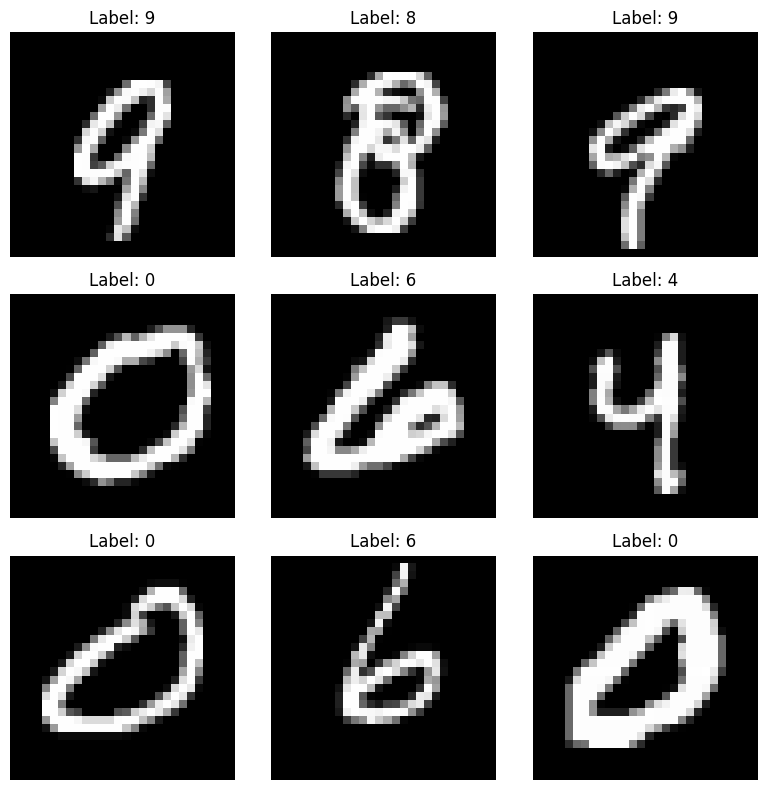

<Figure size 400x200 with 0 Axes>

In [35]:
images, labels = next(iter(train_loader))
images = images.numpy()

# Create a figure and subplot grid
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Iterate over the subplot grid and plot the images
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0], cmap='gray')  # Access the first channel (grayscale) of the image tensor
    ax.axis('off')
    ax.set_title(f'Label: {labels[i]}')

# Display the plot
plt.tight_layout()
plt.figure(figsize=(4, 2))
plt.show()

In [38]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256,120),  #in_features = 16x4x4
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
            nn.Softmax()
        )

        self.flatten = nn.Flatten()

    def forward(self,x):
        a1 = self.feature_extractor(x)
        a1 = self.flatten(a1)
        a2 = self.classifier(a1)
        return a2


In [ ]:
def train(num_epoch, train_loader, model, optimizer, criterion):
    model.train() # This code tells pytorch that you are training your model
    running_loss = 0
    count = 0
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, target) in prog_bar:
        data = data.to(device)
        target = target.to(device)

        # Step 1: Forward pass your input to model
        output = model(data)

        # Step 2: Calculate loss
        loss = criterion(output, target)

        # Step 3: Clears all the accumulated gradients
        optimizer.zero_grad()

        # Step 4: Backpropagate your gradients back
        loss.backward()

        # Step 5: Update your weights based on backpropagated gradients
        optimizer.step()

        running_loss += loss.detach().item()
        count += len(data)

        description = f'Train Loss : {running_loss/count:.4f}'
        prog_bar.set_description(description)

    running_loss /= len(train_loader.dataset)
    print('Train loss: ', running_loss)
    return running_loss

def validate(epoch, test_loader, model, criterion):
    model.eval() # This code tells pytorch that you are evaluating your model
    running_loss = 0
    correct = 0
    count = 0

    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))

    for batch_idx, (data, target) in prog_bar:
        data = data.to(device)
        target = target.to(device)

        # No grad won't track gradients (makes it run faster)
        with torch.no_grad():
            # Forward pass
            output = model(data)

        # Calculate loss
        running_loss += criterion(output, target).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        count += len(data)
        description = f'Validation Loss : {running_loss/count:.4f}'
        prog_bar.set_description(description)

    running_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset) * 100.
    print(f"Average Val Loss: {running_loss:.4f}, Val Accuracy: {accuracy:.2f}")

    print("dataset size:", len(test_loader.dataset))
    print('correctly predicted:', correct.item())
    print(f'accuracy: {accuracy.item():.2f}\n')

    return running_loss, accuracy.item(), correct.item()


In [41]:
seed_everything()
model = LeNet()
model.to(device)

seed_everything()
optimizer = optim.Adam(params=model.parameters(), lr=Config.lr)
loss_fn = nn.CrossEntropyLoss()

losses_train = []
losses_test = []

for epoch in range(Config.epochs):
    print('Epoch', epoch)
    loss_train = train(epoch, train_loader, model, optimizer, loss_fn)
    losses_train.append(loss_train)
    loss_val, acc, crr = validate(epoch, test_loader, model, loss_fn)
    losses_test.append(loss_val)

Epoch 0


  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Train Loss : 0.0517: 100%|██████████| 1875/1875 [00:35<00:00, 52.65it/s]


Train loss:  0.05173776149948438


Validation Loss : 0.0474: 100%|██████████| 313/313 [00:03<00:00, 88.54it/s]


Average Val Loss: 0.0474, Val Accuracy: 94.83
dataset size: 10000
correctly predicted: 9483
accuracy: 94.83

Epoch 1


Train Loss : 0.0472: 100%|██████████| 1875/1875 [00:34<00:00, 54.25it/s]


Train loss:  0.047159358805418015


Validation Loss : 0.0468: 100%|██████████| 313/313 [00:03<00:00, 87.15it/s]


Average Val Loss: 0.0468, Val Accuracy: 96.70
dataset size: 10000
correctly predicted: 9670
accuracy: 96.70

Epoch 2


Train Loss : 0.0467: 100%|██████████| 1875/1875 [00:34<00:00, 54.71it/s]


Train loss:  0.04671790507038434


Validation Loss : 0.0466: 100%|██████████| 313/313 [00:03<00:00, 88.66it/s]


Average Val Loss: 0.0466, Val Accuracy: 97.36
dataset size: 10000
correctly predicted: 9736
accuracy: 97.36

Epoch 3


Train Loss : 0.0466: 100%|██████████| 1875/1875 [00:34<00:00, 54.41it/s]


Train loss:  0.046582637399435044


Validation Loss : 0.0465: 100%|██████████| 313/313 [00:03<00:00, 88.73it/s]


Average Val Loss: 0.0465, Val Accuracy: 97.44
dataset size: 10000
correctly predicted: 9744
accuracy: 97.44

Epoch 4


Train Loss : 0.0464: 100%|██████████| 1875/1875 [00:34<00:00, 54.18it/s]


Train loss:  0.04641439954439799


Validation Loss : 0.0465: 100%|██████████| 313/313 [00:03<00:00, 87.76it/s]


Average Val Loss: 0.0465, Val Accuracy: 97.50
dataset size: 10000
correctly predicted: 9750
accuracy: 97.50

Epoch 5


Train Loss : 0.0463: 100%|██████████| 1875/1875 [00:35<00:00, 52.99it/s]


Train loss:  0.046340314582983655


Validation Loss : 0.0463: 100%|██████████| 313/313 [00:03<00:00, 86.73it/s]


Average Val Loss: 0.0463, Val Accuracy: 98.07
dataset size: 10000
correctly predicted: 9807
accuracy: 98.07

Epoch 6


Train Loss : 0.0463: 100%|██████████| 1875/1875 [00:37<00:00, 50.19it/s]


Train loss:  0.0463066581428051


Validation Loss : 0.0465: 100%|██████████| 313/313 [00:03<00:00, 87.60it/s]


Average Val Loss: 0.0465, Val Accuracy: 97.61
dataset size: 10000
correctly predicted: 9761
accuracy: 97.61

Epoch 7


Train Loss : 0.0463: 100%|██████████| 1875/1875 [00:36<00:00, 51.11it/s]


Train loss:  0.04625549690922101


Validation Loss : 0.0462: 100%|██████████| 313/313 [00:03<00:00, 88.35it/s]


Average Val Loss: 0.0462, Val Accuracy: 98.52
dataset size: 10000
correctly predicted: 9852
accuracy: 98.52

Epoch 8


Train Loss : 0.0462: 100%|██████████| 1875/1875 [00:38<00:00, 49.23it/s]


Train loss:  0.04619873813390732


Validation Loss : 0.0462: 100%|██████████| 313/313 [00:03<00:00, 89.15it/s]


Average Val Loss: 0.0462, Val Accuracy: 98.48
dataset size: 10000
correctly predicted: 9848
accuracy: 98.48

Epoch 9


Train Loss : 0.0462: 100%|██████████| 1875/1875 [00:39<00:00, 47.25it/s]


Train loss:  0.0461594246228536


Validation Loss : 0.0463: 100%|██████████| 313/313 [00:04<00:00, 71.56it/s]

Average Val Loss: 0.0463, Val Accuracy: 98.31
dataset size: 10000
correctly predicted: 9831
accuracy: 98.31



In [42]:
# Save the model weights
model_path = '/content/drive/MyDrive/Adv/tbd_mnist/mnist_lenet5.pt'
torch.save(model.state_dict(), model_path)
print('model saved as', model_path)

model saved as /content/drive/MyDrive/Adv/tbd_mnist/mnist_lenet5.pt


# TBD_MNIST

In [349]:
model_1 = LeNet()
model_1.load_state_dict(torch.load('/content/drive/MyDrive/Adv/tbd_mnist/mnist_lenet5.pt'))

<All keys matched successfully>

In [499]:
desired_class_label = 5
d = 0.4

In [500]:
from skimage.util import random_noise
class SaltAndPepperNoise(object):
    def __init__(self, p=0.2, amount=0.05):
        self.p = p  # Probability of applying salt and pepper noise
        self.amount = amount  # Amount of noise to add

    def __call__(self, sample):
        # Unpack the sample (input tensor)
        image = sample
        image = torch.tensor(random_noise(image, mode='salt', amount=self.amount))
        # # Apply salt and pepper noise with probability p
        # if random.random() < self.p:
        #     # Generate a mask of the same shape as the input tensor
        #     mask = torch.rand(image.size()) < self.amount

        #     # Apply salt noise (set random pixels to maximum value)
        #     image[mask] = 1.0

        #     # Apply pepper noise (set random pixels to minimum value)
        #     image[~mask] = 0.0

        return image

transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    # transforms.GaussianBlur(3),
    transforms.ToTensor(),
    # SaltAndPepperNoise(amount=0.2)
])

seed_everything()
# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_val)
filtered_test_dataset = [item for item in test_dataset if item[1] == desired_class_label]

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)

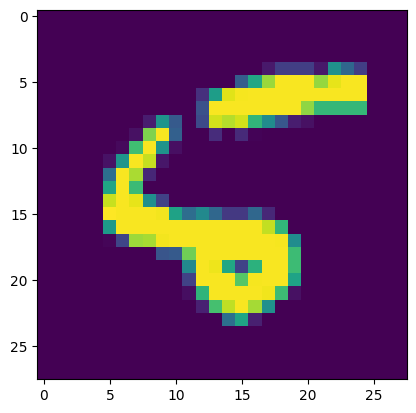

In [501]:
img, label = filtered_test_dataset[0]
plt.imshow(img.squeeze(dim=0))

(1, 28, 28)


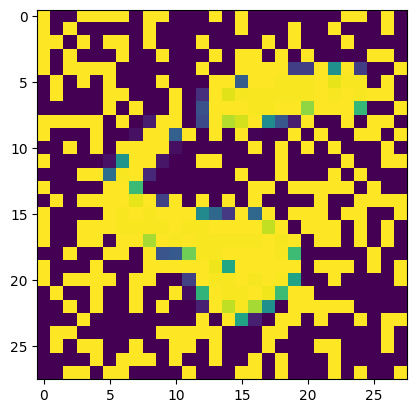

In [502]:
img2 = random_noise(img, mode='salt', amount=d)
print(img2.shape)
plt.imshow(img2.squeeze())

In [503]:
model_1.eval()
softmax_outs = []
preds = []
for i in range(100):
    trans_img = torch.tensor(random_noise(img, mode='salt', amount=d)).unsqueeze(dim=0)
    sfm_output = model_1(trans_img)
    pred = sfm_output.argmax().item()
    softmax_outs.append(sfm_output.detach().numpy())
    preds.append(pred)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [504]:
def gen_list(sfm_outs):
    lists = []
    for i in range(10):
        temp = []
        for j in range(len(sfm_outs)):
            temp.append(sfm_outs[j].squeeze()[i])
        lists.append(temp)
    return lists

lists = gen_list(softmax_outs)

In [506]:
(lists[5])

[0.9200912,
 1.0,
 1.0,
 0.9996123,
 4.0085135e-05,
 0.99917597,
 0.44279712,
 0.0050959666,
 0.9991911,
 0.1032529,
 0.006064193,
 0.028470008,
 0.0017747644,
 1.0,
 0.005435598,
 1.5446038e-05,
 0.9972784,
 0.0034121256,
 8.998272e-06,
 0.9992071,
 0.9997818,
 0.9999963,
 0.9720319,
 0.7886147,
 0.011674662,
 0.011513045,
 0.9999926,
 0.67105824,
 0.9993819,
 1.0,
 0.9516792,
 5.0549024e-06,
 0.08362152,
 1.0,
 1.0,
 1.9075635e-07,
 3.0850617e-06,
 9.313741e-08,
 0.082817286,
 0.0061925654,
 0.9988764,
 1.0,
 3.0954894e-10,
 0.79661614,
 0.03182769,
 3.2990386e-07,
 0.99999654,
 0.9999902,
 0.0004605288,
 0.9998386,
 0.9697874,
 1.5481908e-06,
 0.0008605222,
 0.00030698467,
 1.0,
 1.0,
 7.699354e-10,
 1.6247253e-07,
 0.008092636,
 0.98887396,
 0.00012507186,
 0.9999999,
 3.177548e-09,
 6.626167e-06,
 0.8538063,
 1.0,
 1.0220805e-06,
 0.5389006,
 1.2851008e-05,
 5.221663e-06,
 0.0035960393,
 1.0,
 0.010099361,
 0.004679933,
 0.98791015,
 0.010749342,
 0.9999869,
 0.99811184,
 1.0,
 0.

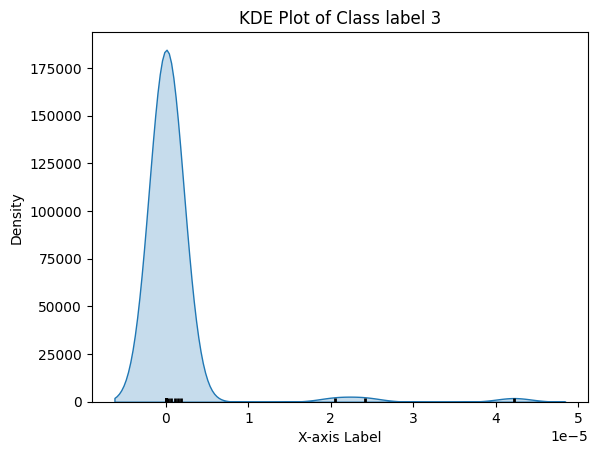

In [507]:
idx = 3
# Sample data (replace this with your own list)
data = lists[idx]

# Create a KDE plot
sns.kdeplot(data, fill=True)  # shade=True adds filled area under the curve
plt.ylim([-0.002, plt.ylim()[1]])
plt.scatter(data, np.full_like(data, -0.001), color='black', marker='|', label='Data Points', linewidths=2)

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title(f'KDE Plot of Class label {idx}')

# Show the plot
plt.show()

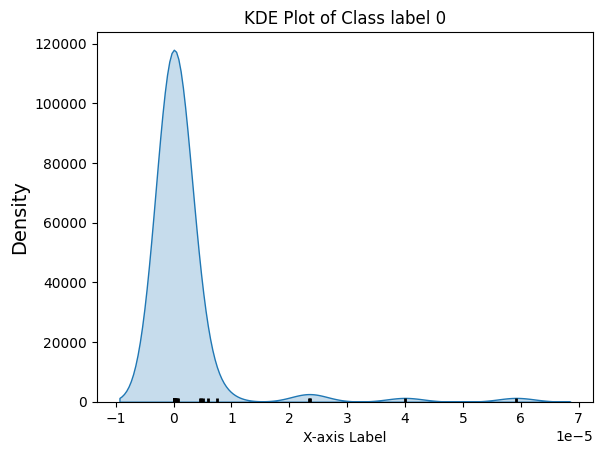

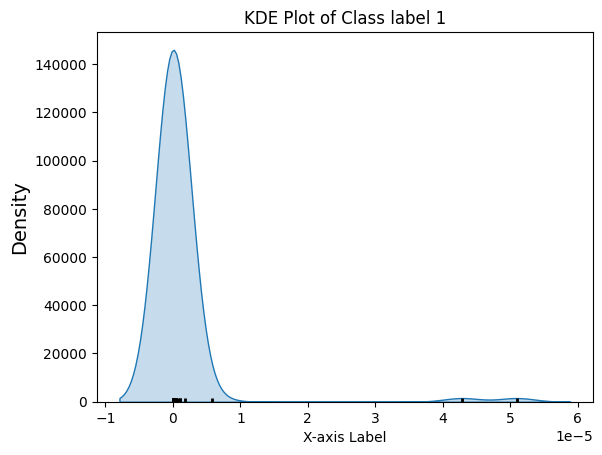

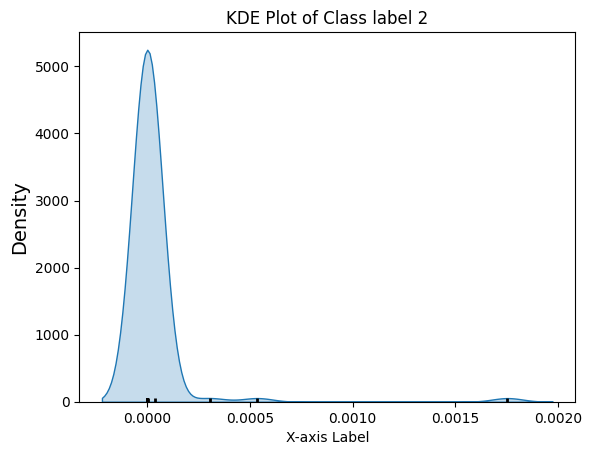

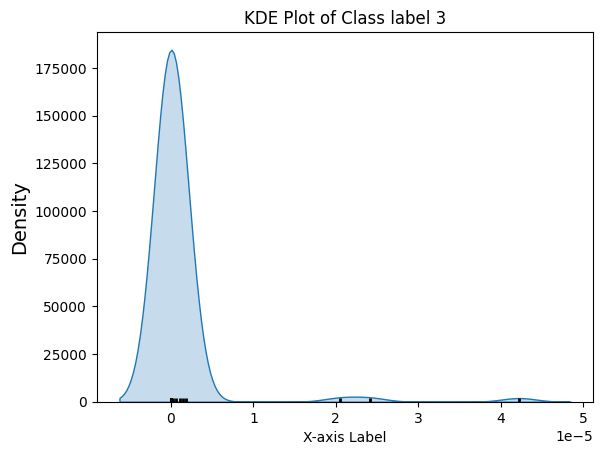

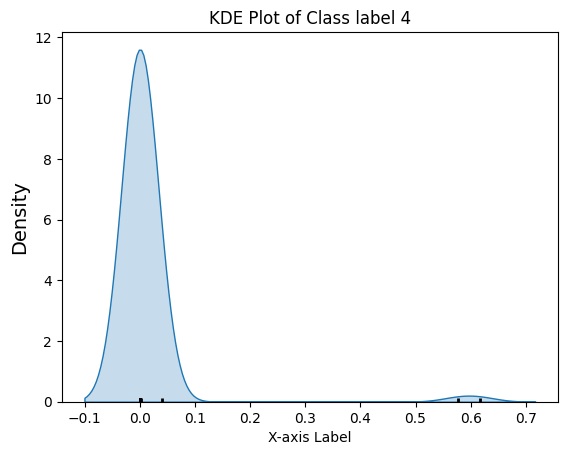

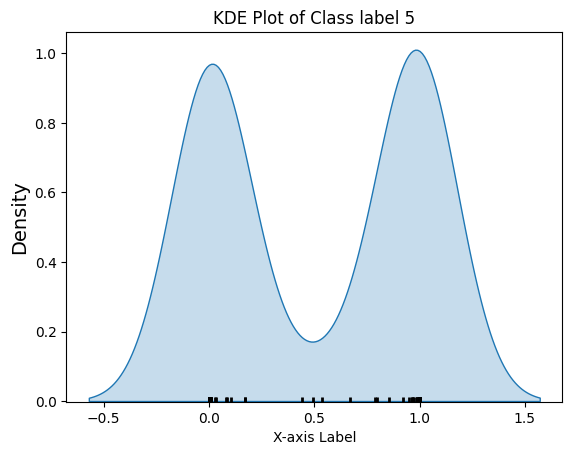

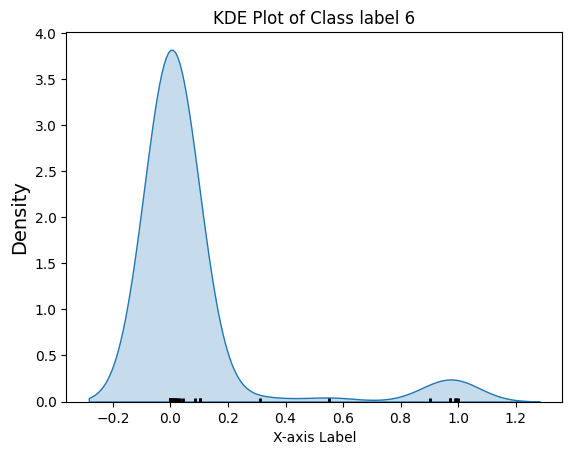

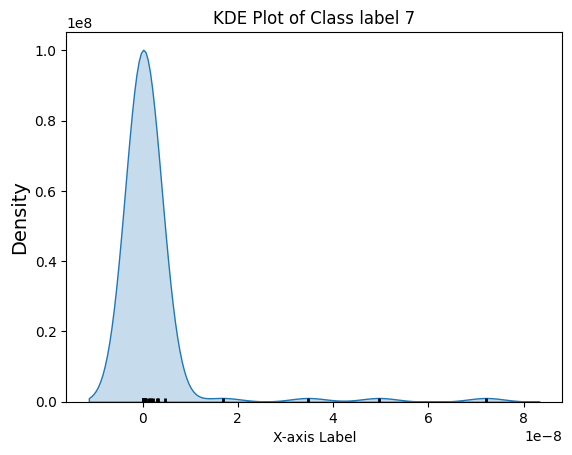

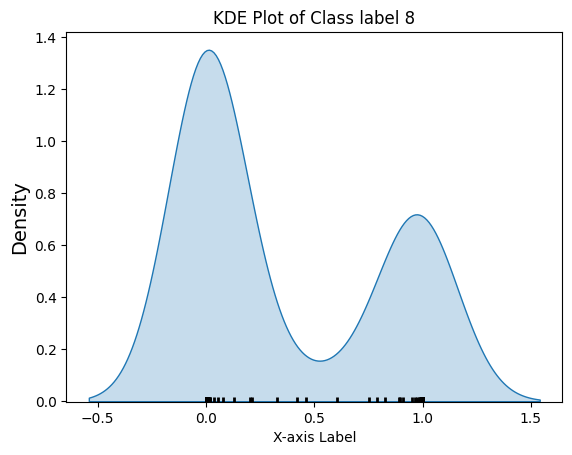

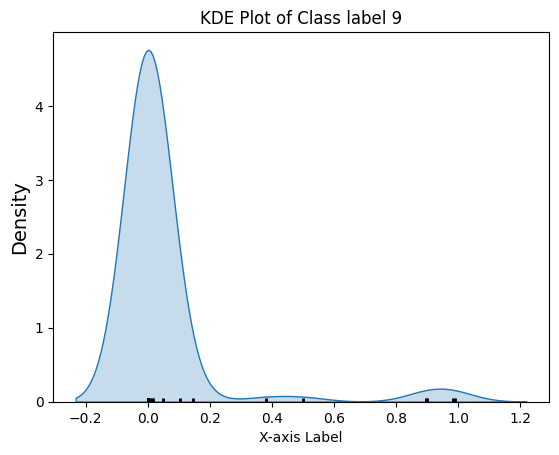

In [508]:
import seaborn as sns
import matplotlib.pyplot as plt

for idx in range(10):
    # Sample data (replace this with your own list)
    data = lists[idx]

    # Create a KDE plot
    sns.kdeplot(data, fill=True)  # shade=True adds filled area under the curve
    plt.ylim([-0.002, plt.ylim()[1]])
    plt.scatter(data, np.full_like(data, -0.001), color='black', marker='|', label='Data Points', linewidths=2)

    # Add labels and title
    plt.xlabel('X-axis Label')
    plt.ylabel('Density', fontsize=14)
    plt.title(f'KDE Plot of Class label {idx}')

    # Show the plot
    plt.show()

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


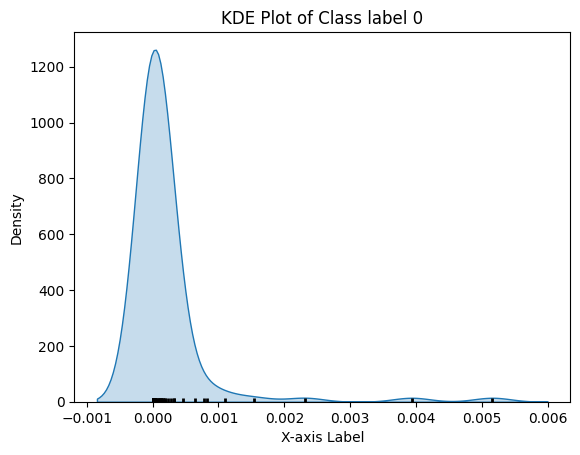

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


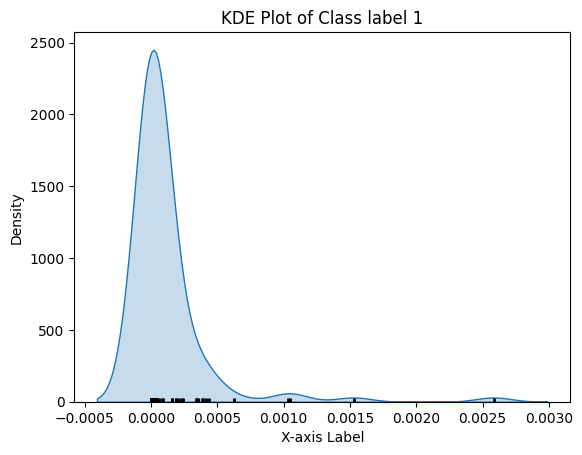

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


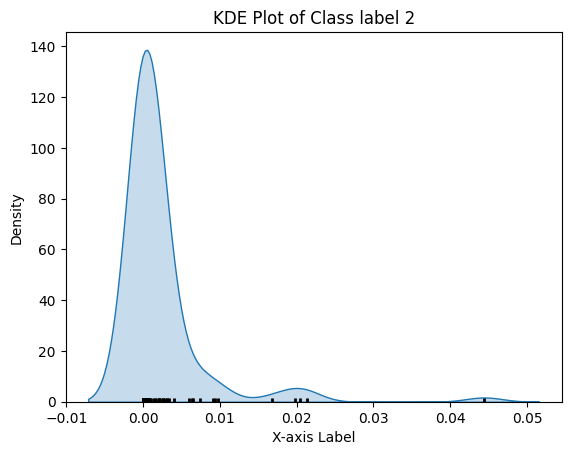

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


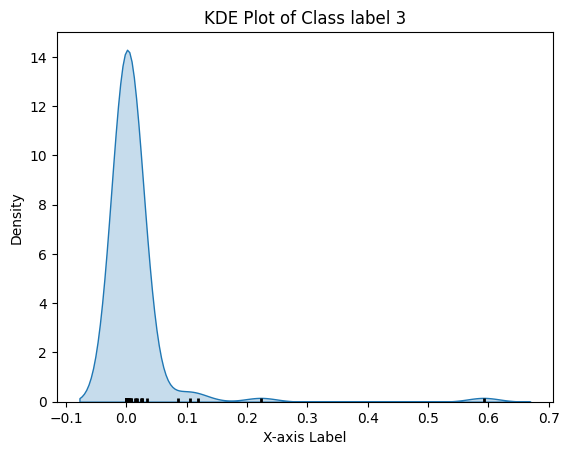

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


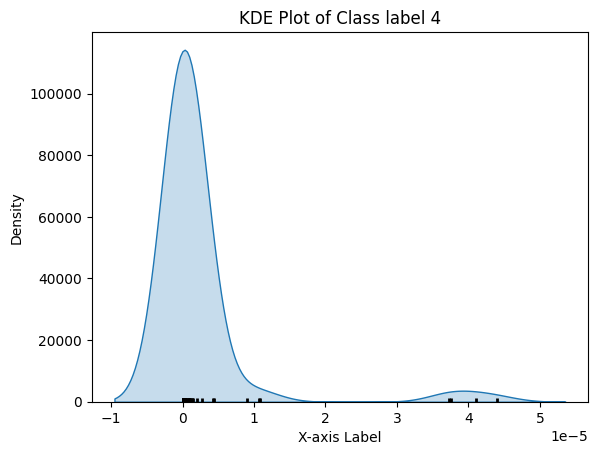

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


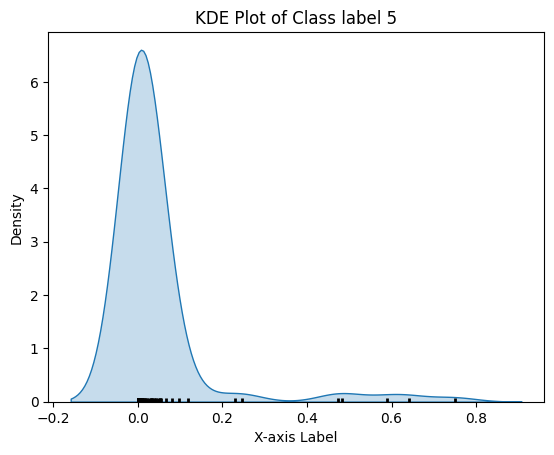

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


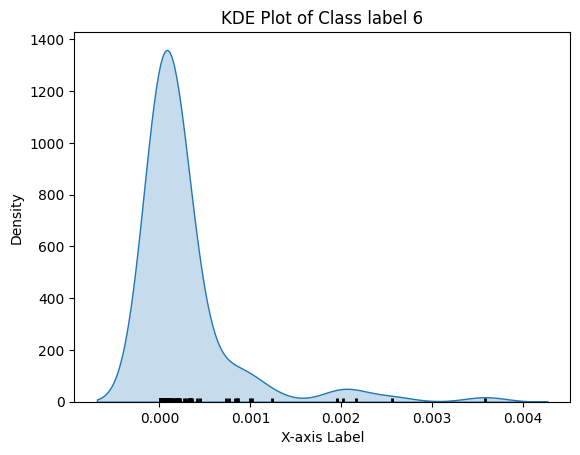

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


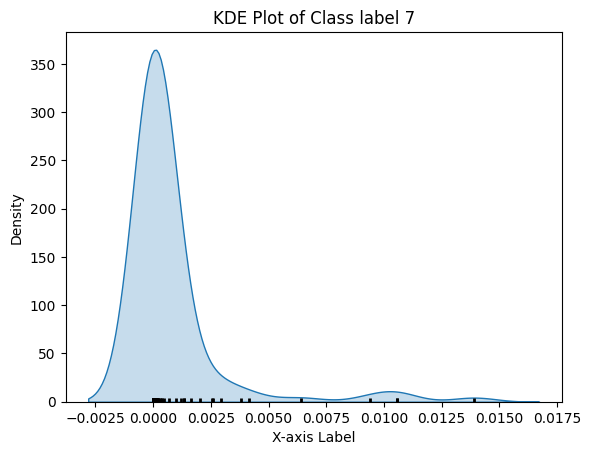

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


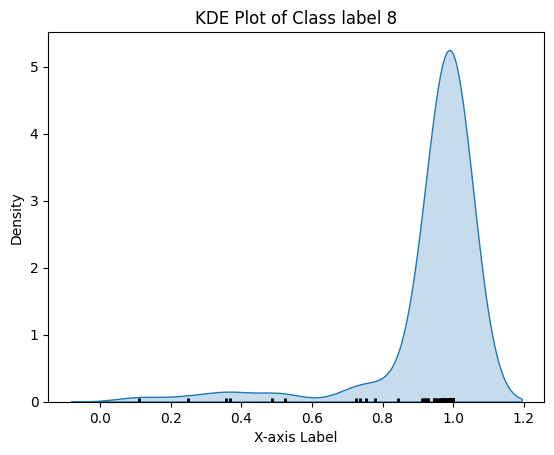

<ipython-input-447-20a3774f3d75>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve


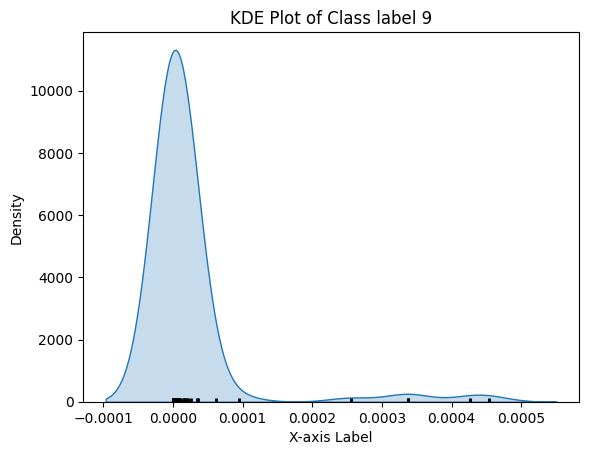

In [447]:
import seaborn as sns
import matplotlib.pyplot as plt

for idx in range(10):
    # Sample data (replace this with your own list)
    data = lists[idx]

    # Create a KDE plot
    sns.kdeplot(data, shade=True)  # shade=True adds filled area under the curve
    plt.ylim([-0.002, plt.ylim()[1]])
    plt.scatter(data, np.full_like(data, -0.001), color='black', marker='|', label='Data Points', linewidths=2)

    # Add labels and title
    plt.xlabel('X-axis Label')
    plt.ylabel('Density')
    plt.title(f'KDE Plot of Class label {idx}')

    # Show the plot
    plt.show()